# Analyzing Remote Sensing and *in situ* Solar Observations of the 24 March 2023 Event with `sunpy` and `pyspedas`

In [8]:
import aiapy
import astropy.time
import astropy.units as u
import pyspedas
import solarmach
import stixpy
import sunpy_soar

from sunpy.net import Fido, attrs as a

## What are we looking at?

In this section, describe the event, when we're looking for it (several days ahead of when it hit Earth), and where the observatories are using `solarmach`

First, let's define the approximate start time of our event.

In [2]:
time_start = astropy.time.Time('2023-03-20 12:00:00')

Next, we can list out all the observatories that we will use in this study so that we can see where they are around the Sun.

In [3]:
spacecraft = [
    'SDO',
    'PSP',
    'Solar Orbiter',
    'STEREO-B',
]

In [5]:
smach = solarmach.SolarMACH(time_start, spacecraft)

No solar wind speeds defined, trying to obtain measurements...
Body 'SDO' not supported, assuming default Vsw value of 400.0 km/s.
No Vsw data found for 'Parker Solar Probe' on 2023-03-20 12:00:00.000, assuming default Vsw value of 400.0 km/s.
No Vsw data found for 'Solar Orbiter' on 2023-03-20 12:00:00.000, assuming default Vsw value of 400.0 km/s.
No Vsw data found for 'STEREO B' on 2023-03-20 12:00:00.000, assuming default Vsw value of 400.0 km/s.


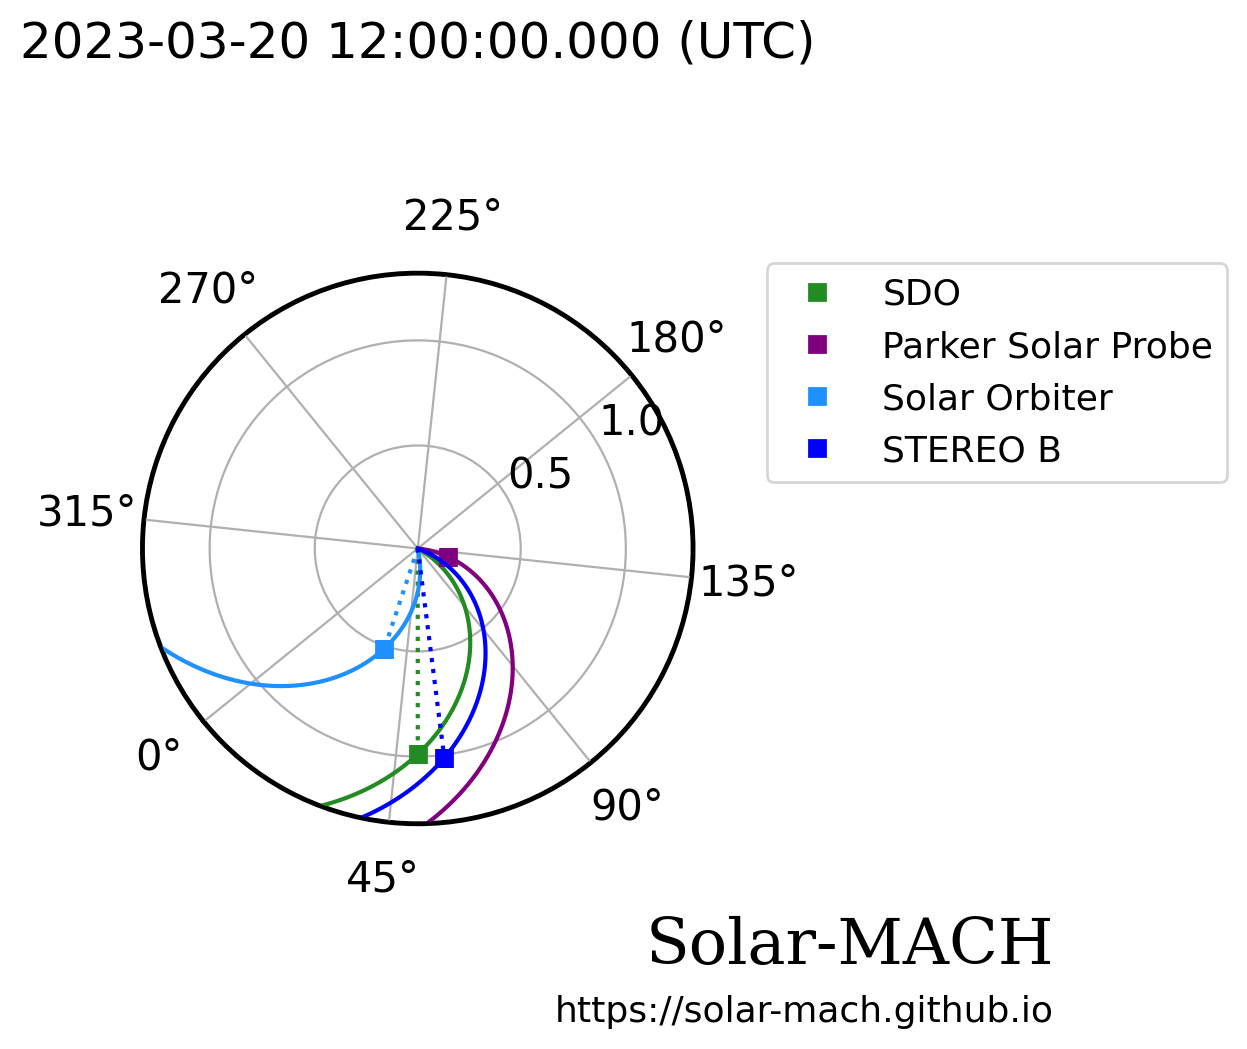

In [6]:
smach.plot(figsize=(6.5,6.5), plot_sun_body_line=True)

## What data do we have?

Our next question is when did this event kick off on the Sun? To do this, we can first look at data from the GOES XRS instrument.

In [7]:
time_query = a.Time(time_start, time_start+6*u.h)

NameError: name 'a' is not defined


Use `Fido` to download:
- GOES XRS lightcurves (this tells us the time we're interested in)
- STIX quicklook lightcurves (this confirms the presence of HXR emission and tells us the time of the flare at SolO)
- AIA 171 and 304
- Solar Orbiter 304
- STEREO-A SECCHI 304
- PSP MAG Data
- PSP WISPR Data
- *Solar Orbiter* EPD data

## Examining the Data

### Remote Sensing

Load the image data with `sunpy`.

### *In situ*

Load the *in situ* data with `pyspedas`. Transform the vector data with `pyspedas` (?)

Look at the ribbons in the EUV image data
Look at the variations in the *in situ* data
Look at the corresponding heliospheric white light data with WISPR

## How do we combine the data?

We ultimately want to answer the question of what the origin of this storm is on the Sun

Reproject the SECCHI, AIA, and EUI data into a single synoptic EUV map. Backmap from PSP to the solar surface using SolarMach

Reproject one of the EUV images with the WISPR data to gain a view of the heliosphere from the corona out into the solar wind